In [1]:
### Import libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy 
import re
import os
import sys 
import matplotlib.dates
# import sqlite3
# import sqlalchemy

# import warnings
from datetime import datetime
from tabulate import tabulate
from matplotlib import style
style.use('dark_background')


In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("clean.csv", index_col=0)
total_click=0
temp_click=np.zeros(10000)
index=np.zeros(10000)
for i in np.array(range(0,10000,1)):
    total_click=total_click+df.click[i+1]
    index[i] = i+1
    temp_click[i]=total_click
#    acme['Clickcount'][i]=total_click
df['total_count']=temp_click
df['id']=index
df['1'] = pd.get_dummies(df['rank'])[1]
df['2'] = pd.get_dummies(df['rank'])[2]
df['3'] = pd.get_dummies(df['rank'])[3]
df['4'] = pd.get_dummies(df['rank'])[4]
df['5'] = pd.get_dummies(df['rank'])[5]
df['nov'] = pd.get_dummies(df['number_of_vehicles'])[2]
df['nod'] = pd.get_dummies(df['number_of_drivers'])[2]
df = df.drop('number_of_vehicles',axis=1)
df = df.drop('number_of_drivers',axis=1)
df=df.astype('int32')

temp_click[0]

1.0

In [4]:
df.head()

,click,currently_insured,rank,policies sold,married,total_count,id,1,2,3,4,5,nov,nod
impression_id,,,,,,,,,,,,,,
1,1,0,1,1,1,1,1,1,0,0,0,0,0,0
2,0,0,4,0,1,1,2,0,0,0,1,0,1,0
3,0,0,2,0,0,1,3,0,1,0,0,0,0,0
4,0,1,5,0,1,1,4,0,0,0,0,1,1,0
5,0,1,4,0,0,1,5,0,0,0,1,0,1,1


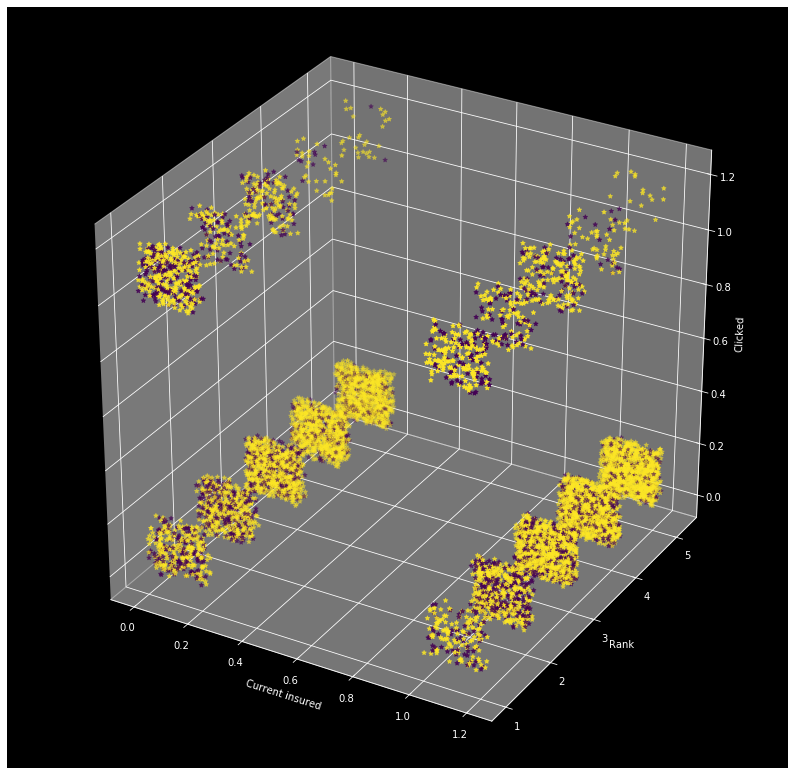

In [5]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
RAND_RANGE = .2
x = np.array(df['currently_insured'])+np.random.uniform(0,RAND_RANGE,10000)
y = np.array(df['rank'])+np.random.uniform(0,RAND_RANGE,10000)
z = np.array(df['click'])+np.random.uniform(0,RAND_RANGE,10000)

ax.scatter(x, y, z, c=df['married'], marker='*')
ax.set_xlabel('Current insured')
ax.set_ylabel('Rank')
ax.set_zlabel('Clicked')

plt.show()

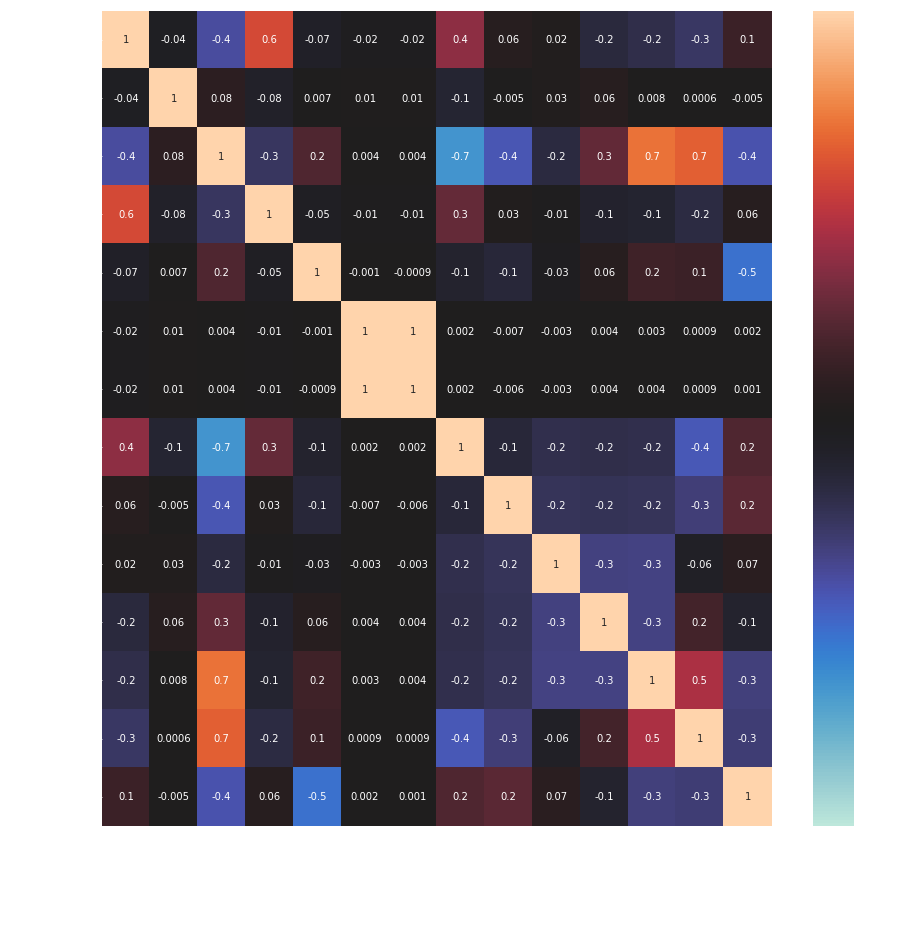

In [6]:
plt.figure(figsize=(15,15))

sns.heatmap(df.corr(),annot=True,fmt='.1g', vmin=-1, vmax=1, center= 0)


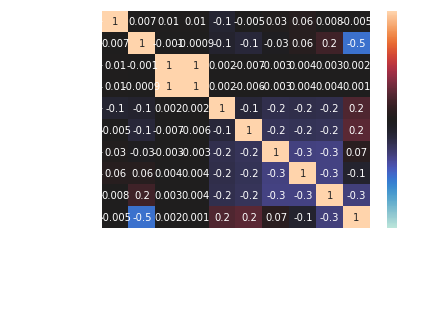

In [7]:
predictdf=df.drop(columns=['click','policies sold','rank', 'nov'])
sns.heatmap(predictdf.corr(),annot=True,fmt='.1g', vmin=-1, vmax=1, center= 0)


# Classification problem

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


In [9]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nov','nod']), df['click'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nov','id','total_count']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nod']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', '1','2','3','4','5']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'total_count']), df['click'], test_size=0.2, random_state=42)

#Prediction for policysold
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['policies sold','rank']), df['policies sold'], test_size=0.2, random_state=42)

In [10]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)
poly.fit(X_train, y_train)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=True,
                   order='C')

In [11]:
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)


# Logistic Regression

In [12]:
logiReg = LogisticRegression()
logiReg.fit(X_train, y_train)
y_pred_logi = logiReg.predict_proba(X_test)[:,1]
p_range=np.array(range(1, 4000,10))/ 10000
#Initialize the accuracy and recall matrix
acc_temp=np.zeros(len(p_range))
rec_temp=np.zeros(len(p_range))
realp_temp=np.zeros(len(p_range))
auc_temp=np.zeros(len(p_range))
logloss_temp=np.zeros(len(p_range))

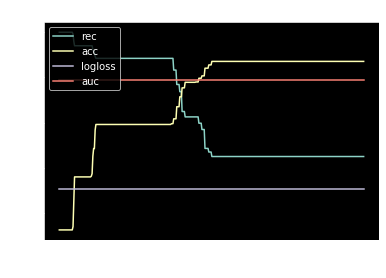

In [13]:
p_index=0
for p in p_range:
    threshold = p
    y_pred_prob = y_pred_logi
    y_pred = y_pred_prob > threshold
    #print('p=', p)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)    
    #print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
    #print('Log loss:', log_loss(y_test, y_pred_prob))
    #print('Accuracy score:', accuracy_score(y_test, y_pred)) 
    #print("Recall rate:", recall_score(y_test, y_pred))
    #print('AUC metric:', auc(fpr, tpr))
    auc_temp[p_index]=auc(fpr, tpr)
    logloss_temp[p_index]=log_loss(y_test, y_pred_prob)
    acc_temp[p_index]=accuracy_score(y_test, y_pred)
    rec_temp[p_index]=recall_score(y_test, y_pred)
    realp_temp[p_index]=p
    p_index=p_index+1

plotdata={"acc": acc_temp,
          "rec": rec_temp,
          "logloss": logloss_temp,
          "auc":auc_temp,
            "p": realp_temp,}
plotdf = pd.DataFrame(plotdata)
plt.plot(plotdf['p'],plotdf['rec'])
plt.plot(plotdf['p'],plotdf['acc'])
plt.plot(plotdf['p'],plotdf['logloss'])
plt.plot(plotdf['p'],plotdf['auc'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('p')
plt.legend(['rec', 'acc','logloss','auc'], loc='upper left')
plt.show()

Exam the special case with some special p

In [14]:
    threshold = 0.16
    y_pred_prob = y_pred_logi
    y_pred = y_pred_prob > threshold
    print('p=', threshold)
    print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
    print('Log loss:', log_loss(y_test, y_pred_prob))
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    print("Recall rate:", recall_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    print('AUC metric:', auc(fpr, tpr))


p= 0.16
Prob of clicking: 0.1255 0.345
Log loss: 0.30657655360884667
Accuracy score: 0.7145
Recall rate: 0.7370517928286853
AUC metric: 0.7894710466310856


In [15]:
confusion_matrix(y_test, y_pred)

array([[1244,  505],
       [  66,  185]], dtype=int64)

# Lasso

In [16]:
from sklearn.linear_model import Lasso

In [262]:
alpha=0.0007
lasso = Lasso(alpha, normalize = True, max_iter = 1000000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
threshold = 0.18
y_pred_prob_lasso = y_pred_lasso
y_pred_lasso = y_pred_prob_lasso > threshold
print('Log loss:', log_loss(y_test, y_pred_prob_lasso))
print('Accuracy score:', accuracy_score(y_test, y_pred_lasso)) 
print("Recall rate:", recall_score(y_test, y_pred_lasso))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lasso)    
print('AUC metric:', auc(fpr, tpr))

Log loss: 0.3289203734153508
Accuracy score: 0.7785
Recall rate: 0.6254980079681275
AUC metric: 0.792739846787806


# Ridge

In [18]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
threshold = 0.165
y_pred_prob_ridge = y_pred_ridge
y_pred_ridge = y_pred_prob_ridge > threshold
print('Log loss:', log_loss(y_test, y_pred_prob_ridge))
print('Accuracy score:', accuracy_score(y_test, y_pred_ridge)) 
print("Recall rate:", recall_score(y_test, y_pred_ridge))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ridge)    
print('AUC metric:', auc(fpr, tpr))

Log loss: 0.3072814287042985
Accuracy score: 0.7785
Recall rate: 0.6254980079681275
AUC metric: 0.7894710466310856


## Ensemble learning

In [19]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
y_pred_gb = gb_clf.predict_proba(X_test)[:,1]

In [21]:
for p in np.array(range(1500, 2700,2)) / 10000:
    threshold = p
    y_pred_prob = y_pred_gb
    y_pred = y_pred_gb > threshold
    print('p=', p)
    #print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
    #print('Log loss:', log_loss(y_test, y_pred_prob))
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    print("Recall rate:", recall_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    print('AUC metric:', auc(fpr, tpr))

p= 0.15
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1502
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1504
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1506
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1508
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.151
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1512
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1514
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1516
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.1518
Accuracy score: 0.6575
Recall rate: 0.8007968127490039
AUC metric: 0.7928810771778523
p= 0.152
Accuracy score: 0.6575
Recall rate

AUC metric: 0.7928810771778523
p= 0.1718
Accuracy score: 0.7685
Recall rate: 0.6334661354581673
AUC metric: 0.7928810771778523
p= 0.172
Accuracy score: 0.7685
Recall rate: 0.6334661354581673
AUC metric: 0.7928810771778523
p= 0.1722
Accuracy score: 0.7685
Recall rate: 0.6334661354581673
AUC metric: 0.7928810771778523
p= 0.1724
Accuracy score: 0.7685
Recall rate: 0.6334661354581673
AUC metric: 0.7928810771778523
p= 0.1726
Accuracy score: 0.793
Recall rate: 0.6095617529880478
AUC metric: 0.7928810771778523
p= 0.1728
Accuracy score: 0.793
Recall rate: 0.6095617529880478
AUC metric: 0.7928810771778523
p= 0.173
Accuracy score: 0.793
Recall rate: 0.6095617529880478
AUC metric: 0.7928810771778523
p= 0.1732
Accuracy score: 0.793
Recall rate: 0.6095617529880478
AUC metric: 0.7928810771778523
p= 0.1734
Accuracy score: 0.793
Recall rate: 0.6095617529880478
AUC metric: 0.7928810771778523
p= 0.1736
Accuracy score: 0.793
Recall rate: 0.6095617529880478
AUC metric: 0.7928810771778523
p= 0.1738
Accurac

Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1946
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1948
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.195
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1952
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1954
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1956
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1958
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.196
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1962
Accuracy score: 0.827
Recall rate: 0.5258964143426295
AUC metric: 0.7928810771778523
p= 0.1964
Accuracy score: 0.827
Recall rate: 0.525896414342629

Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2172
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2174
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2176
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2178
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.218
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2182
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2184
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2186
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2188
Accuracy score: 0.8695
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.219
Accuracy score: 0.8695
Recall rate: 0.45019920318725

Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2388
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.239
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2392
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2394
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2396
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2398
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.24
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2402
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2404
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2406
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p

Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2608
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.261
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2612
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2614
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2616
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2618
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.262
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2622
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2624
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523
p= 0.2626
Accuracy score: 0.871
Recall rate: 0.450199203187251
AUC metric: 0.7928810771778523


## Neural Network

In [22]:
from sklearn.neural_network import MLPClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense
import keras_metrics
from keras import backend as K
from keras.utils import to_categorical
from sklearn.metrics import log_loss, recall_score, confusion_matrix, \
                            auc, accuracy_score, roc_curve


Using TensorFlow backend.
E:\Users\Jigglypuff\anaconda3\envs\Erdos\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Users\Jigglypuff\anaconda3\envs\Erdos\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Users\Jigglypuff\anaconda3\envs\Erdos\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Users\Jigglypuff\anaconda3\en

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [24]:
y_pred_nn = mlp.predict(X_test)
y_pred_prob_nn = mlp.predict_proba(X_test)

In [25]:
print(log_loss(y_test, y_pred_prob_nn))
print(accuracy_score(y_test, y_pred_nn))
print(recall_score(y_test, y_pred_nn))

0.3089567225935739
0.871
0.450199203187251


In [26]:
print('meann of predict:',np.mean(y_pred_nn) )
print('meann of test:',np.mean(y_test) )


meann of predict: 0.1165
meann of test: 0.1255


# Multilayer NN

In [27]:
#define plot of recall,precision,loss
def recall_plot(history):
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def precision_plot(history):
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def loss_plot(history):
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show()

In [28]:
def precision_threshold(threshold=0.5):
    def precision(y_true, y_pred):
        """Precision metric.
        Computes the precision over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # count the predicted positives
        predicted_positives = K.sum(y_pred)
        # Get the precision ratio
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        """Recall metric.
        Computes the recall over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # Compute the number of positive targets.
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

In [230]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'total_count','id']), df['click'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','1','2','3','4','5', 'id', 'total_count']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nod']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', '1','2','3','4','5']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'total_count']), df['click'], test_size=0.2, random_state=42)


In [234]:
model = Sequential()
model.add(Dense(20, input_dim=len(X_train.columns), activation='sigmoid'))
model.add(Dense(25, activation='sigmoid'))
#model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision_threshold(0.15), recall_threshold(0.15)])
#precision_threshold(0.5), recall_threshold(0.5)
#keras.metrics.Precision(), keras.metrics.Recall()

In [195]:
X_test.shape

(2000, 5)

In [239]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=100, batch_size=64)


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 0s 38us/step - loss: 0.3253 - precision: 0.3189 - recall: 0.6793 - val_loss: 0.3113 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 2/100
8000/8000 [==============================] - 0s 40us/step - loss: 0.3251 - precision: 0.3093 - recall: 0.6738 - val_loss: 0.3147 - val_precision: 0.2530 - val_recall: 0.7314
Epoch 3/100
8000/8000 [==============================] - 0s 42us/step - loss: 0.3253 - precision: 0.3019 - recall: 0.7048 - val_loss: 0.3102 - val_precision: 0.2606 - val_recall: 0.7112
Epoch 4/100
8000/8000 [==============================] - 0s 41us/step - loss: 0.3252 - precision: 0.3028 - recall: 0.6843 - val_loss: 0.3123 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 5/100
8000/8000 [==============================] - 0s 45us/step - loss: 0.3253 - precision: 0.2982 - recall: 0.6968 - val_loss: 0.3115 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 6/100
8000/8000 

8000/8000 [==============================] - 0s 39us/step - loss: 0.3248 - precision: 0.3008 - recall: 0.6941 - val_loss: 0.3095 - val_precision: 0.3071 - val_recall: 0.6331
Epoch 45/100
8000/8000 [==============================] - 0s 41us/step - loss: 0.3250 - precision: 0.3076 - recall: 0.6914 - val_loss: 0.3110 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 46/100
8000/8000 [==============================] - 0s 39us/step - loss: 0.3248 - precision: 0.2970 - recall: 0.7063 - val_loss: 0.3118 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 47/100
8000/8000 [==============================] - 0s 38us/step - loss: 0.3249 - precision: 0.3027 - recall: 0.7057 - val_loss: 0.3113 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 48/100
8000/8000 [==============================] - 0s 39us/step - loss: 0.3249 - precision: 0.3060 - recall: 0.6941 - val_loss: 0.3114 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 49/100
8000/8000 [==============================] - 0s 37us/step - loss:

Epoch 88/100
8000/8000 [==============================] - 0s 34us/step - loss: 0.3245 - precision: 0.3170 - recall: 0.6862 - val_loss: 0.3153 - val_precision: 0.2526 - val_recall: 0.7314
Epoch 89/100
8000/8000 [==============================] - 0s 35us/step - loss: 0.3246 - precision: 0.2980 - recall: 0.7048 - val_loss: 0.3117 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 90/100
8000/8000 [==============================] - 0s 35us/step - loss: 0.3252 - precision: 0.3041 - recall: 0.6885 - val_loss: 0.3099 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 91/100
8000/8000 [==============================] - 0s 33us/step - loss: 0.3245 - precision: 0.3007 - recall: 0.7061 - val_loss: 0.3092 - val_precision: 0.3071 - val_recall: 0.6331
Epoch 92/100
8000/8000 [==============================] - 0s 34us/step - loss: 0.3247 - precision: 0.3053 - recall: 0.7045 - val_loss: 0.3097 - val_precision: 0.2621 - val_recall: 0.7191
Epoch 93/100
8000/8000 [==============================] - 0s 31us

In [107]:
score = model.evaluate(X_test, y_test)
score

2000/2000 [==============================] - 0s 22us/step


[0.396060140132904, 0.16216152906417847, 0.9297240376472473]

In [ ]:
recall_plot(history)
precision_plot(history)
loss_plot(history)